In [1]:
# 1. IMPORTE & VORBEREITUNG
# *************************

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation, NMF
import matplotlib.pyplot as plt
import numpy as np

# Downloads für NLTK (nur beim ersten Mal nötig)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# 2. DATEN LADEN 
# *************************

try:
    # Wir laden nur eine Stichprobe, um Speicherplatz zu sparen
    df = pd.read_csv('rows_sample.csv', low_memory=False)
    display(df)
    
    # Filtern: Nur Zeilen mit Textinhalt behalten
    df = df[['Consumer complaint narrative']].dropna().reset_index(drop=True)
    
    # Definition von df_sample (die ersten 1000 Zeilen für den Testlauf)
    df_sample = df.head(1000).copy()

    
    print(f"Erfolgreich geladen: {len(df_sample)} Datensätze.")
except FileNotFoundError:
    print("Fehler: Die Datei 'rows_sample.csv' wurde nicht gefunden.")

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/23/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,The Summer of XX/XX/2018 I was denied a mortga...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",IL,NaN,NaN,Consent provided,Web,03/23/2019,Closed with explanation,Yes,NaN,3189109
1,03/22/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,There are many mistakes appear in my report wi...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",VA,220XX,NaN,Consent provided,Web,03/22/2019,Closed with explanation,Yes,NaN,3187982
2,03/22/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,There are many mistakes appear in my report wi...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,770XX,NaN,Consent provided,Web,03/22/2019,Closed with explanation,Yes,NaN,3187954
3,03/22/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,There are many mistakes appear in my report wi...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,787XX,NaN,Consent provided,Web,03/22/2019,Closed with explanation,Yes,NaN,3188091
4,03/22/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,There are many mistakes appear in my report wi...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,951XX,NaN,Consent provided,Web,03/22/2019,Closed with explanation,Yes,NaN,3188119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,01/29/2019,Checking or savings account,Checking account,Managing an account,Fee problem,"On Sunday, XX/XX/2019 I attempted to withdraw ...",Company has responded to the consumer and the ...,"SUNTRUST BANKS, INC.",GA,301XX,NaN,Consent provided,Web,01/29/2019,Closed with monetary relief,Yes,NaN,3136661
9996,01/29/2019,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,LOANCARE bought our loan XX/XX/XXXX. \nThey ha...,Company has responded to the consumer and the ...,"LoanCare, LLC",CO,800XX,NaN,Consent provided,Web,01/30/2019,Closed with explanation,Yes,NaN,3136831
9997,01/29/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Public record information inaccurate,RE : BANKRUPTCY ACCOUNTS NOT IDENTIFIED To Who...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,OH,432XX,NaN,Consent provided,Web,01/29/2019,Closed with explanation,Yes,NaN,3136813
9998,01/29/2019,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"I have been called almost every day, sometimes...",Company has responded to the consumer and the ...,"HCFS Health Care Financial Services, Inc.",CA,946XX,NaN,Consent provided,Web,02/05/2019,Closed with explanation,No,NaN,3134831


Erfolgreich geladen: 1000 Datensätze.


In [3]:
# 3. VORVERARBEITUNG
# *************************
def preprocess_text(text):
    # 1. Kleinschreibung
    text = text.lower()
    
    # 2. Entfernen von Sonderzeichen und Zahlen (Regex)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # 3. Tokenisierung (Text in Wörter zerlegen)
    words = text.split()
    
    # 4. Stopword-Entfernung (Häufige Wörter wie 'the', 'is' ohne Eigenbedeutung)
    stop_words = set(stopwords.words('english'))

    # OPTIMIERUNG: Spezifische Platzhalter x aus dem Datensatz entfernen
    placeholder_stopwords = {'xxxx', 'xxxxxxxx', 'xxxxx', 'xx', 'xxx'}
    stop_words.update(placeholder_stopwords)

    # Filterung
    words = [w for w in words if w not in stop_words]
    
    # 5. Lemmatisierung (Wörter auf Grundform zurückführen)
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]
    
    return " ".join(words)

# Anwendung der Vorverarbeitung auf den Datensatz
df_sample['clean_text'] = df_sample['Consumer complaint narrative'].apply(preprocess_text)

print("Original:")
print(df_sample['Consumer complaint narrative'].iloc[0][:100], "...")
print("\nGereinigt:")
print(df_sample['clean_text'].iloc[0][:100], "...")

Original:
The Summer of XX/XX/2018 I was denied a mortgage loan due to a charge off from XXXX XXXX credit card ...

Gereinigt:
summer denied mortgage loan due charge credit card mailed account validation letter disputed debt cr ...


In [4]:
# 4. VEKTORISIERUNG Bag-of-Words (1.Technik)
# ******************************************

# Initialisierung des CountVectorizers
bow_vectorizer = CountVectorizer(max_features=1000) # Auf 1000 Wörter begrenzen

# Transformation der bereinigten Texte
bow_matrix = bow_vectorizer.fit_transform(df_sample['clean_text'])

# Umwandlung in ein DataFrame -> bessere Ansicht
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=bow_vectorizer.get_feature_names_out())
print("Bag-of-Words Matrix (Ausschnitt):")
print(bow_df.head())

Bag-of-Words Matrix (Ausschnitt):
   aafes  ability  able  accept  accepted  access  accident  according  \
0      0        0     0       0         0       0         0          0   
1      0        0     0       0         0       0         0          0   
2      0        0     0       0         0       0         0          0   
3      0        0     0       0         0       0         0          0   
4      0        0     0       0         0       0         0          0   

   account  accounting  ...  working  would  wouldnt  write  writing  written  \
0        1           0  ...        0      0        0      0        0        0   
1        0           0  ...        0      0        0      0        0        0   
2        0           0  ...        0      0        0      0        0        0   
3        0           0  ...        0      0        0      0        0        0   
4        0           0  ...        0      0        0      0        0        0   

   wrong  wrote  year  yet  
0    

In [5]:
display(bow_df)

,aafes,ability,able,accept,accepted,access,accident,according,account,accounting,...,working,would,wouldnt,write,writing,written,wrong,wrote,year,yet
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,3,0,...,0,1,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [6]:
# 4. VEKTORISIERUNG TF-IDF (2. Technik)
# *********************************************************************************

tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# Transformation
tfidf_matrix = tfidf_vectorizer.fit_transform(df_sample['clean_text'])

feature_names = tfidf_vectorizer.get_feature_names_out()

def top_terms_for_doc(doc_index, top_n=10):
    # 1 Zeile (Dokument) aus der TF-IDF Matrix holen
    row = tfidf_matrix[doc_index].toarray().ravel()

    # Indizes der höchsten TF-IDF Werte
    top_idx = np.argsort(row)[::-1][:top_n]

    # Ergebnis als Tabelle
    result = pd.DataFrame({
        "term": feature_names[top_idx],
        "tfidf": row[top_idx]
    })

    # nur >0 anzeigen (Wörter, die im Dokument wirklich vorkommen)
    return result[result["tfidf"] > 0].reset_index(drop=True)

# Beispiel: Top-Wörter für das 1. Dokument (Index 0)
print("Original (Ausschnitt):")
print(df_sample["Consumer complaint narrative"].iloc[0][:200], "...")

print("\nTop TF-IDF Wörter (Dokument 0):")
display(top_terms_for_doc(0, top_n=15))

Original (Ausschnitt):
The Summer of XX/XX/2018 I was denied a mortgage loan due to a charge off from XXXX XXXX credit card. I both mailed an account validation letter and disputed this debt with the credit bureaus and the  ...

Top TF-IDF Wörter (Dokument 0):


,term,tfidf
0,letter,0.340764
1,proof,0.333591
2,debt,0.305255
3,responded,0.292939
4,verified,0.271237
5,bureau,0.267564
6,credit,0.230767
7,card,0.182371
8,sent,0.162675
9,really,0.155999


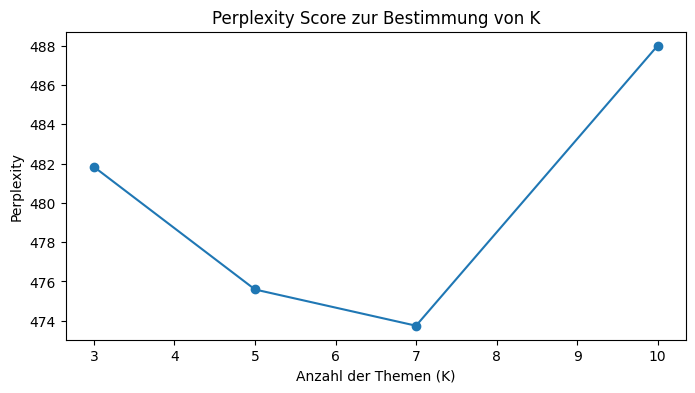

In [7]:
# 5. BESTIMMUNG VON K (TOPIC COUNT) [Feedback Tutor]
# ******************************************************
# optimale Anzahl an Themen (K) mittels Perplexity herausfinden
# ->Ein niedrigerer Perplexity-Wert deutet auf eine bessere Modellpassung hin.
search_params = [3, 5, 7, 10]
perplexity_scores = []

for k in search_params:
    lda_model = LatentDirichletAllocation(n_components=k, random_state=42)
    lda_model.fit(bow_matrix)
    perplexity_scores.append(lda_model.perplexity(bow_matrix))

# Plotten der Ergebnisse zur Begründung von K [cite: 182, 183]
plt.figure(figsize=(8, 4))
plt.plot(search_params, perplexity_scores, marker='o')
plt.title("Perplexity Score zur Bestimmung von K")
plt.xlabel("Anzahl der Themen (K)")
plt.ylabel("Perplexity")
plt.show()


In [8]:
# 6. SEMANTISCHE ANALYSE
#****************************
# wählen K=7 basierend auf Perplexity
best_k = 7

# Technik 1: LDA
lda = LatentDirichletAllocation(n_components=best_k, random_state=42)
lda.fit(bow_matrix)

# Technik 2: NMF
nmf = NMF(n_components=best_k, random_state=42)
nmf.fit(tfidf_matrix)

# Hilfsfunktion zur Anzeige der Themen
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        words = " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(f"Thema #{topic_idx}: {words}")

print("\n--- LDA Ergebnisse ---")
print_top_words(lda, bow_vectorizer.get_feature_names_out(), 10)

print("\n--- NMF Ergebnisse ---")
print_top_words(nmf, tfidf_vectorizer.get_feature_names_out(), 10)


--- LDA Ergebnisse ---
Thema #0: credit report account information identity inquiry reporting experian theft oh
Thema #1: loan payment modification fee without many received report would mortgage
Thema #2: account credit balance due reporting past paid collection report reported
Thema #3: called call told would said time back company number pay
Thema #4: debt credit collection letter account information company sent report received
Thema #5: account bank credit card payment would day time fee told
Thema #6: payment loan late mortgage year day month interest time would

--- NMF Ergebnisse ---
Thema #0: account credit report information reporting experian removed file remove please
Thema #1: understanding appear mistake many without report noticed loan personal college
Thema #2: past due balance account reporting harming transunion impossible corrected partial
Thema #3: bank told would card call called loan payment said back
Thema #4: debt collection letter company validation sent colle